In [13]:
import pyodbc 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

In [14]:
# Prepare Data
# Import
def wrangle(db):
    # Connect to database
    conn = pyodbc.connect(db)

    # retrieve only buildings that are in Gorkha(Gorkha (district 4)) and the damage_grade
    query = """
    SELECT DISTINCT (i.building_id) as b_id,s.*,d.damage_grade
    FROM id_map$ as i
    JOIN building_structure$ as s on i.building_id=s.building_id
    JOIN building_damage$ as d on i.building_id=d.building_id
    where district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query,conn,index_col="b_id")
    
    drop_cols=[col for col in df.columns if "post_eq" in col]
    
    df['damage_grade']=df['damage_grade'].str[-1].astype(int)
    df["severe_damage"]=(df['damage_grade']>3).astype(int)
    drop_cols.append('damage_grade')
    drop_cols.append("count_floors_pre_eq")
    drop_cols.append ("building_id")
    #drop leaky cols
    df.drop(columns=drop_cols , inplace=True)
    
    return df


In [15]:
# connect to the database.
df=wrangle('Driver={SQL Server};'
        'Server=DESKTOP-C6O0T9S;'
        'Database=PortfolioProject;'
        'Trusted_Connection=yes;')
df.head()

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12512\3526804517.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn,index_col="b_id")


,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
195476.0,25.0,525.0,15.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
184524.0,25.0,222.0,20.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
166790.0,13.0,150.0,16.0,Flat,Cement-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,"Stone, mud mortar",1
200427.0,30.0,600.0,12.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Timber-Planck,Not attached,Rectangular,"Stone, mud mortar",1
181791.0,3.0,1080.0,9.0,Moderate slope,Cement-Stone/Brick,RCC/RB/RBC,RC,Not applicable,Not attached,Square,"Brick, cement mortar",0


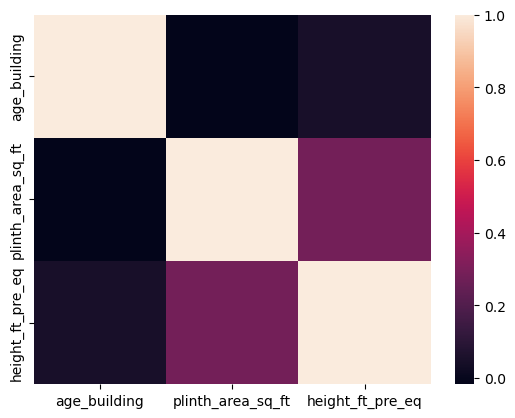

In [23]:
# Explore
# correlation matrix
correlation =df.select_dtypes('number').drop(columns ='severe_damage').corr()
# heatmap of `correlation`
sns.heatmap(correlation);

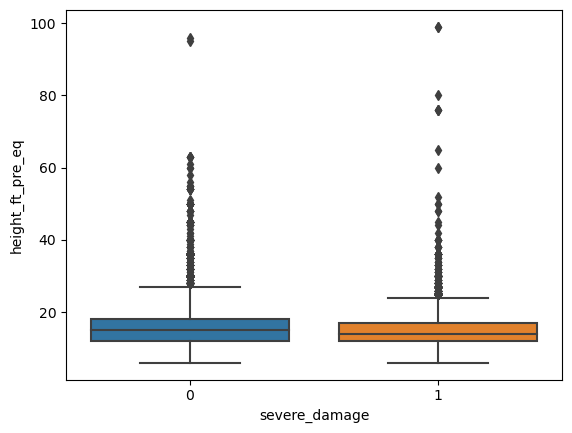

In [24]:
# boxplot shows the 'height_ft_pre_eq' distributions for 'severe_damage' values
sns.boxplot(x='severe_damage',y='height_ft_pre_eq',data=df);

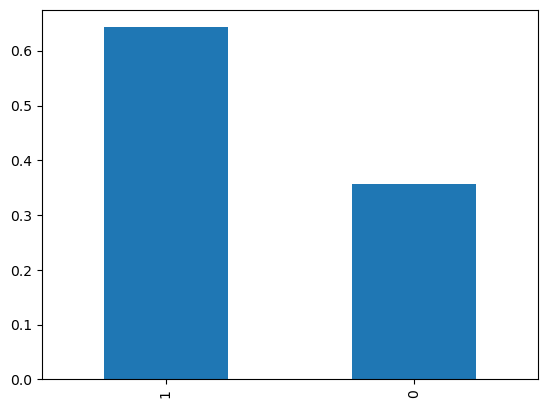

In [22]:
# bar chart of the value counts for the "severe_damage" column
df['severe_damage'].value_counts(normalize=True).plot(kind='bar');

In [25]:
# majority and minority classes
majority_class_prop, minority_class_prop = df['severe_damage'].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6425969845841097 0.3574030154158902


In [26]:
# Are buildings with certain foundation types more likely to suffer severe damage?
foundation_pivot =pd.pivot_table(index='foundation_type',values='severe_damage',aggfunc=np.mean,data=df).sort_values('severe_damage')
foundation_pivot

,severe_damage
foundation_type,
RC,0.026224
Bamboo/Timber,0.324074
Cement-Stone/Brick,0.421908
Mud mortar-Stone/Brick,0.687792
Other,0.818898


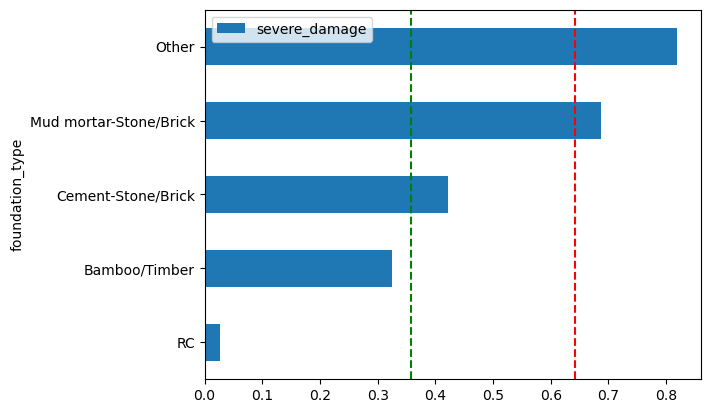

In [28]:
# horizontal bar chart for foundation_pivot
foundation_pivot.plot(kind='barh')
plt.axvline(majority_class_prop,linestyle ="--",color="red")
plt.axvline(minority_class_prop,linestyle ="--",color="green");

In [29]:
# high- & low-cardinality categorical features in the dataset.
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
superstructure            11
dtype: int64

In [30]:
# Split
target = "severe_damage"
X = df.drop (columns=target )
y = df[target]

In [31]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (56668, 11)
y_train shape: (56668,)
X_test shape: (14168, 11)
y_test shape: (14168,)


In [32]:
# Build Model
# Baseline
# baseline accuracy score
acc_baseline = df['severe_damage'].value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


In [33]:
# Iterate
model =make_pipeline(
    OneHotEncoder(),
    LogisticRegression(max_iter=1000) 
)

model.fit(X_train,y_train )
check_is_fitted(model)

C:\Users\PanDa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [34]:
# the training and test accuracy scores
acc_train = accuracy_score(y_train,model.predict (X_train))
acc_test = model.score(X_test,y_test)
print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.72
Test Accuracy: 0.71


In [35]:
# Communicate
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps['logisticregression'].coef_[0]
odds_ratios = pd.Series(np.exp(importances),index=features ).sort_values()
odds_ratios.head()

C:\Users\PanDa\anaconda3\lib\site-packages\category_encoders\utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


superstructure_1       0.259541
foundation_type_1      0.331520
roof_type_3            0.386121
ground_floor_type_3    0.501926
other_floor_type_4     0.570319
dtype: float64

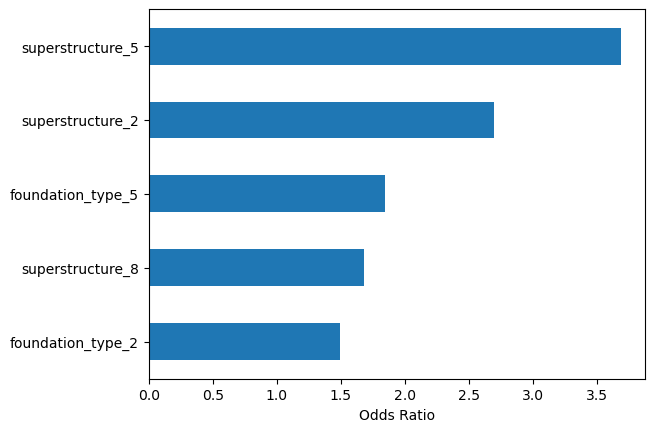

In [36]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind="barh")
plt.xlabel("Odds Ratio");

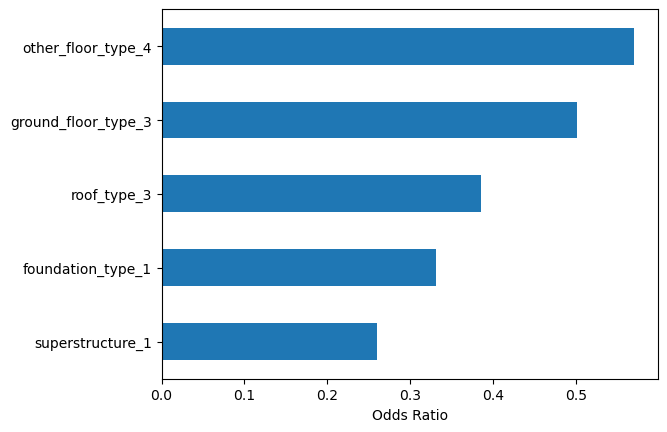

In [37]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind="barh")
plt.xlabel("Odds Ratio");
